In [49]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


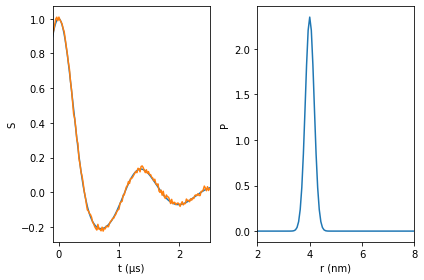

In [50]:
nr = 100
nt = 150

t = np.linspace(-0.1,2.5,nt)        # time axis, µs
r = np.linspace(2,8,nr)      # distance axis, ns

r0 = 4 
fwhm = 0.4 # parameters for three-Gaussian model
Ptrue = dive.dd_gauss(r,r0,fwhm)          # model distance distribution

# param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
# P0 = dl.dd_gauss2(r,param2)  

lam = 0.5
k = 0.1
V0 = 1                      # modulation depth

B = dive.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r)    # kernel matrix
sigma = 0.01

S0 = K@Ptrue
S = S0 + dl.whitegaussnoise(t,sigma,seed=0)

# Vexp = dive.deerTrace(K@P0,B,V0,lam) + dl.whitegaussnoise(t,sigma,seed=0)

fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, S0)
line1 = ax[0].plot(t, S)
line2 = ax[1].plot(r, Ptrue)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

In [51]:
KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL = np.matmul(np.transpose(L),L)

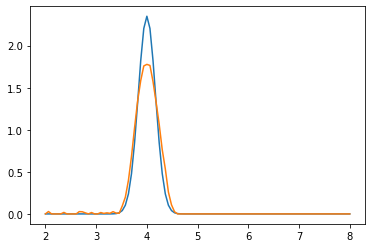

In [52]:
tau = 1/(sigma**2)
delta = 1000

Pdraw = dive.randP(delta,tau,KtK,KtS,LtL,nr)
Pdraw = Pdraw/sum(Pdraw)/(r[1]-r[0])

plt.plot(r,Ptrue)
plt.plot(r,Pdraw);


### Same for the full model (draw using V) 

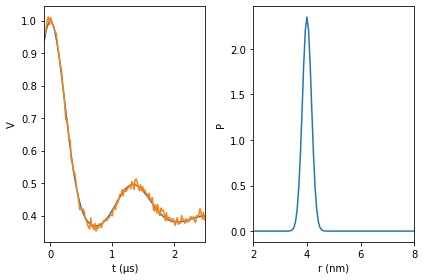

In [53]:
KB = dl.dipolarkernel(t,r,mod = lam, bg = B)    # kernel matrix

sigma = 0.01

Vtrue = KB@Ptrue 
Vexp = Vtrue + dl.whitegaussnoise(t,sigma,seed=0)

fig, ax = plt.subplots(1,2)
line1 = ax[0].plot(t, Vtrue)
line0 = ax[0].plot(t, Vexp)
line2 = ax[1].plot(r, Ptrue)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'V')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

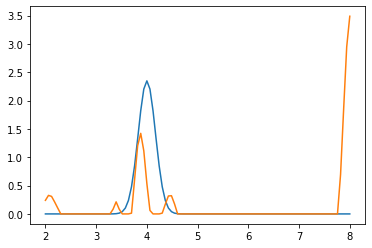

In [56]:
lam = 0.9
k = 0.01

KB = dl.dipolarkernel(t,r,mod = lam, bg = B)    # kernel matrix

KtK = np.matmul(np.transpose(KB),KB)
KtS = np.matmul(np.transpose(KB),Vexp)

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL = np.matmul(np.transpose(L),L)

tau = 100/(sigma**2)
delta = 10000

Pdraw = dive.randP(delta,tau,KtK,KtS,LtL,nr)
Pdraw = Pdraw/sum(Pdraw)/(r[1]-r[0])

plt.plot(r,Ptrue)
plt.plot(r,Pdraw);